In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import shutil
import cv2
import os

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
dataset_path = '../dataset/original_data/'

In [4]:
print(os.listdir(dataset_path))

['benign', 'malignant', 'non-nodule']


## Plot x-rays

Helper function to plot the images in a grid

In [5]:
def ceildiv(a, b):
    return -(-a // b)

def plots_from_files(imspaths, figsize=(10,5), rows=1, titles=None, maintitle=None):
    """Plot the images in a grid"""
    f = plt.figure(figsize=figsize)
    if maintitle is not None: plt.suptitle(maintitle, fontsize=10)
    for i in range(len(imspaths)):
        sp = f.add_subplot(rows, ceildiv(len(imspaths), rows), i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        img = plt.imread(imspaths[i])
        plt.imshow(img)

In [6]:
benign_images = list(paths.list_images(f"{dataset_path}/benign"))
malignant_images = list(paths.list_images(f"{dataset_path}/malignant"))
non_nodule_images = list(paths.list_images(f"{dataset_path}/non-nodule"))

In [7]:
# plots_from_files(benign_images, rows=5, maintitle="benign X-ray images")

In [8]:
# plots_from_files(malignant_images, rows=5, maintitle="malignant-19 X-ray images")

In [9]:
# plots_from_files(non_nodule_images, rows=5, maintitle="non-nodule-19 X-ray images")

## Data preprocessing

In [10]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-3
EPOCHS = 150
BS = 8

In [11]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset_path))
# print(imagePaths)



[INFO] loading images...


In [12]:
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    splitnames = imagePath.split('/')
    splitnames_2 = splitnames[3].split('\\')
#     print(splitnames_2[0])
    
    # extract the class label from the filename
    label = splitnames_2[0]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

In [13]:
labels

array(['benign', 'benign', 'benign', 'benign', 'benign', 'benign',
       'benign', 'benign', 'benign', 'benign', 'benign', 'benign',
       'benign', 'benign', 'benign', 'benign', 'benign', 'benign',
       'benign', 'benign', 'benign', 'benign', 'benign', 'benign',
       'benign', 'benign', 'benign', 'benign', 'benign', 'benign',
       'benign', 'benign', 'benign', 'benign', 'benign', 'benign',
       'benign', 'benign', 'benign', 'benign', 'benign', 'benign',
       'benign', 'benign', 'benign', 'benign', 'benign', 'benign',
       'benign', 'benign', 'benign', 'benign', 'benign', 'benign',
       'malignant', 'malignant', 'malignant', 'malignant', 'malignant',
       'malignant', 'malignant', 'malignant', 'malignant', 'malignant',
       'malignant', 'malignant', 'malignant', 'malignant', 'malignant',
       'malignant', 'malignant', 'malignant', 'malignant', 'malignant',
       'malignant', 'malignant', 'malignant', 'malignant', 'malignant',
       'malignant', 'malignant', 'mal

In [14]:
np.unique(labels)

array(['benign', 'malignant', 'non-nodule'], dtype='<U10')

In [15]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels_one_hot = lb.fit_transform(labels)
labels_one_hot

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0,

In [16]:
from sklearn import preprocessing
import pandas as pd

df = pd.DataFrame(labels)
print(df.head())
print()
print(df[0].unique())


        0
0  benign
1  benign
2  benign
3  benign
4  benign

['benign' 'malignant' 'non-nodule']


In [17]:
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'species'.
df[0]= label_encoder.fit_transform(df[0])
  
df[0].unique()


array([0, 1, 2])

In [18]:
label_int = df[0].tolist()
label_int

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

In [19]:
labels_catagorical = to_categorical(label_int)
labels_catagorical

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0

In [20]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels_catagorical, test_size=0.20)
# initialize the training data augmentation object
trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

In [21]:
trainX

array([[[[0.74509804, 0.74509804, 0.74509804],
         [0.68627451, 0.68627451, 0.68627451],
         [0.6745098 , 0.6745098 , 0.6745098 ],
         ...,
         [0.13333333, 0.13333333, 0.13333333],
         [0.01568627, 0.01568627, 0.01568627],
         [0.        , 0.        , 0.        ]],

        [[0.77254902, 0.77254902, 0.77254902],
         [0.71764706, 0.71764706, 0.71764706],
         [0.68235294, 0.68235294, 0.68235294],
         ...,
         [0.16862745, 0.16862745, 0.16862745],
         [0.01960784, 0.01960784, 0.01960784],
         [0.        , 0.        , 0.        ]],

        [[0.78431373, 0.78431373, 0.78431373],
         [0.74901961, 0.74901961, 0.74901961],
         [0.71764706, 0.71764706, 0.71764706],
         ...,
         [0.21568627, 0.21568627, 0.21568627],
         [0.01960784, 0.01960784, 0.01960784],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.78431373, 0.78431373, 0.78431373],
         [0.80784314, 0.80784314, 0.80784314]

In [22]:
testX

array([[[[0.        , 0.        , 0.        ],
         [0.01568627, 0.01568627, 0.01568627],
         [0.02745098, 0.02745098, 0.02745098],
         ...,
         [0.10196078, 0.10196078, 0.10196078],
         [0.09803922, 0.09803922, 0.09803922],
         [0.10588235, 0.10588235, 0.10588235]],

        [[0.        , 0.        , 0.        ],
         [0.01568627, 0.01568627, 0.01568627],
         [0.03137255, 0.03137255, 0.03137255],
         ...,
         [0.09803922, 0.09803922, 0.09803922],
         [0.10196078, 0.10196078, 0.10196078],
         [0.10588235, 0.10588235, 0.10588235]],

        [[0.        , 0.        , 0.        ],
         [0.01568627, 0.01568627, 0.01568627],
         [0.03137255, 0.03137255, 0.03137255],
         ...,
         [0.11372549, 0.11372549, 0.11372549],
         [0.11372549, 0.11372549, 0.11372549],
         [0.11372549, 0.11372549, 0.11372549]],

        ...,

        [[0.99607843, 0.99607843, 0.99607843],
         [1.        , 1.        , 1.        ]

In [23]:
trainY

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0

In [24]:
testY

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0

## Model

In [25]:
# load the DenseNet201 network, ensuring the head FC layer sets are left
# off
baseModel = DenseNet201(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

### Training

In [27]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/150
24/24 [==============================] - 63s 2s/step - loss: 1.3602 - accuracy: 0.4083 - val_loss: 1.0912 - val_accuracy: 0.4400
Epoch 2/150
24/24 [==============================] - 2s 77ms/step - loss: 1.1804 - accuracy: 0.4217 - val_loss: 1.0825 - val_accuracy: 0.3400
Epoch 3/150
24/24 [==============================] - 2s 76ms/step - loss: 1.1512 - accuracy: 0.3317 - val_loss: 1.0844 - val_accuracy: 0.3600
Epoch 4/150
24/24 [==============================] - 2s 78ms/step - loss: 1.0542 - accuracy: 0.4910 - val_loss: 1.1035 - val_accuracy: 0.3000
Epoch 5/150
24/24 [==============================] - 2s 79ms/step - loss: 1.0027 - accuracy: 0.4685 - val_loss: 1.0975 - val_accuracy: 0.3200
Epoch 6/150
24/24 [==============================] - 2s 78ms/step - loss: 1.0044 - accuracy: 0.4963 - val_loss: 1.1074 - val_accuracy: 0.3400
Epoch 7/150
24/24 [==============================] - 2s 77ms/step - loss: 1.0187 - accuracy: 0.4263

24/24 [==============================] - 2s 79ms/step - loss: 0.7372 - accuracy: 0.6174 - val_loss: 1.1366 - val_accuracy: 0.4000
Epoch 58/150
24/24 [==============================] - 2s 77ms/step - loss: 0.7305 - accuracy: 0.6266 - val_loss: 1.1806 - val_accuracy: 0.4600
Epoch 59/150
24/24 [==============================] - 2s 77ms/step - loss: 0.7335 - accuracy: 0.6359 - val_loss: 1.1749 - val_accuracy: 0.4600
Epoch 60/150
24/24 [==============================] - 2s 78ms/step - loss: 0.7709 - accuracy: 0.6420 - val_loss: 1.2911 - val_accuracy: 0.4200
Epoch 61/150
24/24 [==============================] - 2s 78ms/step - loss: 0.7441 - accuracy: 0.6241 - val_loss: 1.2240 - val_accuracy: 0.3800
Epoch 62/150
24/24 [==============================] - 2s 76ms/step - loss: 0.6865 - accuracy: 0.6956 - val_loss: 1.3044 - val_accuracy: 0.4000
Epoch 63/150
24/24 [==============================] - 2s 77ms/step - loss: 0.6978 - accuracy: 0.6428 - val_loss: 1.2186 - val_accuracy: 0.4000
Epoch 64/150

24/24 [==============================] - 2s 77ms/step - loss: 0.5825 - accuracy: 0.7300 - val_loss: 1.4124 - val_accuracy: 0.4000
Epoch 115/150
24/24 [==============================] - 2s 77ms/step - loss: 0.4994 - accuracy: 0.7718 - val_loss: 1.4460 - val_accuracy: 0.4400
Epoch 116/150
24/24 [==============================] - 2s 79ms/step - loss: 0.5732 - accuracy: 0.7328 - val_loss: 1.4189 - val_accuracy: 0.5000
Epoch 117/150
24/24 [==============================] - 2s 78ms/step - loss: 0.5097 - accuracy: 0.7629 - val_loss: 1.4331 - val_accuracy: 0.4400
Epoch 118/150
24/24 [==============================] - 2s 77ms/step - loss: 0.5062 - accuracy: 0.7549 - val_loss: 1.5444 - val_accuracy: 0.4400
Epoch 119/150
24/24 [==============================] - 2s 76ms/step - loss: 0.5212 - accuracy: 0.7920 - val_loss: 1.4539 - val_accuracy: 0.4000
Epoch 120/150
24/24 [==============================] - 2s 78ms/step - loss: 0.5195 - accuracy: 0.7542 - val_loss: 1.4530 - val_accuracy: 0.4400
Epoch 

### Plot trining metrics

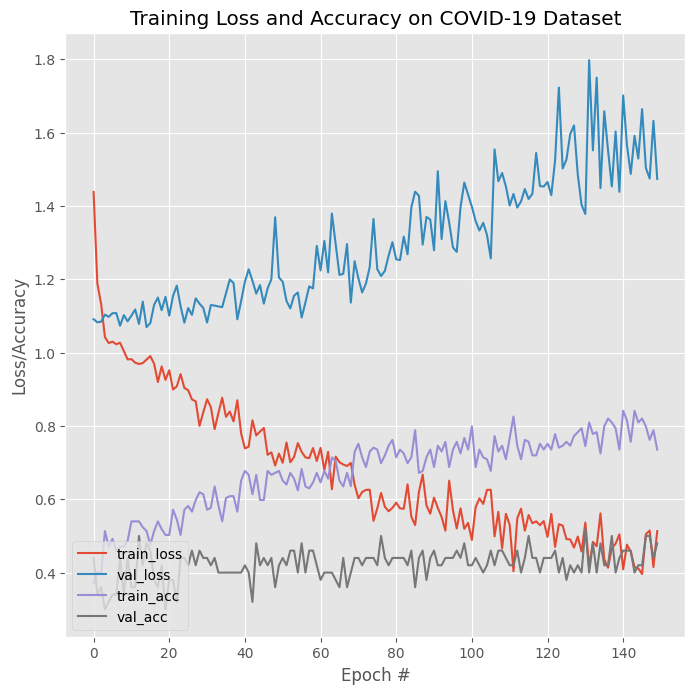

In [28]:

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure(figsize=(8,8), dpi=100)
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")


### Evaluation

In [29]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

report = classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_)

with open('classification_report.txt','w') as f:
    f.write(report)
    


[INFO] evaluating network...
              precision    recall  f1-score   support

      benign       0.50      0.17      0.25        12
   malignant       0.60      0.65      0.63        23
  non-nodule       0.33      0.47      0.39        15

    accuracy                           0.48        50
   macro avg       0.48      0.43      0.42        50
weighted avg       0.50      0.48      0.46        50



#### Confusion matrix

In [30]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))



[[ 2  3  7]
 [ 1 15  7]
 [ 1  7  7]]
acc: 0.3400
sensitivity: 0.4000
specificity: 0.9375


In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    
    plt.figure(figsize=(8,8), dpi=100)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.savefig('Confusion_matrix.png')
    

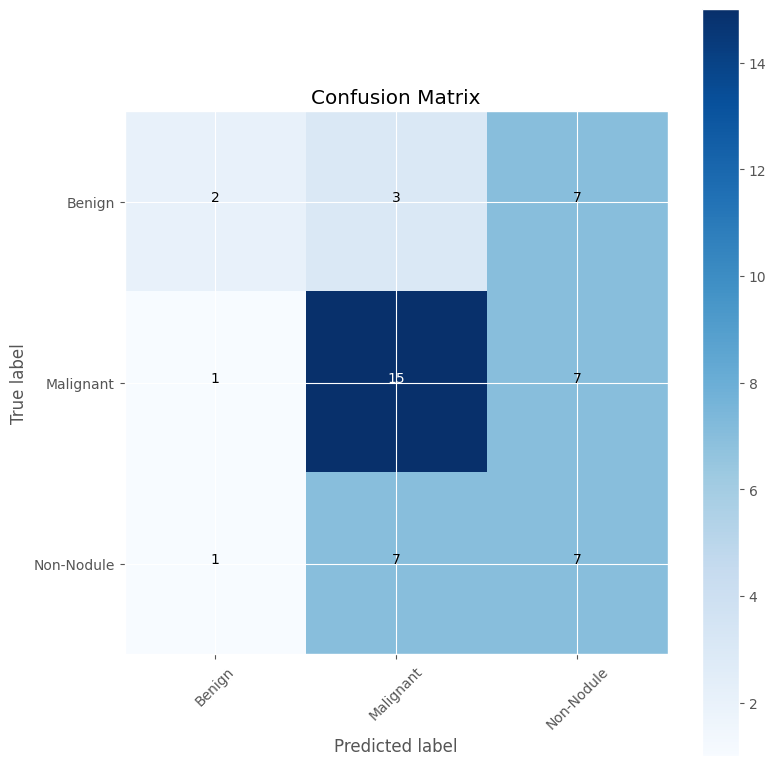

In [32]:
cm_plot_labels = ['Benign','Malignant', 'Non-Nodule']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')


Now save the model

In [33]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('DenseNet201_Lung_Cancer_model.h5') 

Test loaded model

In [34]:
from tensorflow.keras.models import load_model
# Recreate the exact same model, including its weights and the optimizer
new_model = load_model('DenseNet201_Lung_Cancer_model.h5')

# Show the model architecture
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [35]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = new_model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

      benign       0.50      0.17      0.25        12
   malignant       0.60      0.65      0.63        23
  non-nodule       0.33      0.47      0.39        15

    accuracy                           0.48        50
   macro avg       0.48      0.43      0.42        50
weighted avg       0.50      0.48      0.46        50



Test on image:

[[0.0000000e+00 2.4345933e-27 1.0000000e+00]]
[2]


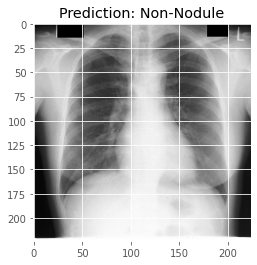

In [36]:
import numpy as np
from tensorflow.keras.preprocessing import image

img_width, img_height = 224, 224
img = image.load_img('..\dataset\original_data\malignant\JPCLN145.png', target_size = (img_width, img_height))
x = image.img_to_array(img)
img = np.expand_dims(x, axis = 0)

pred = new_model.predict(img)
print(pred)

#one = new_model.predict('../input/covid-chest-xray/images/1-s2.0-S1684118220300608-main.pdf-002.jpg', batch_size = BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
print(np.argmax(pred, axis=1))

if np.argmax(pred, axis=1) == 0:
    plt.title('Prediction: Benign')
elif np.argmax(pred, axis=1) == 1:
    plt.title('Prediction: Malignant')
elif np.argmax(pred, axis=1) == 2:
    plt.title('Prediction: Non-Nodule')
    
plt.imshow(x/255.)
plt.savefig('plot_out.png')